## Benchmark IN-trained classifiers on `ImageNet-Hard`

<a target="_blank" href="https://colab.research.google.com/github/taesiri/ZoomIsAllYouNeed/blob/main/src/ImageNet_Hard/Benchmark-ImageNet-Hard.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

* [Website](https://taesiri.github.io/ZoomIsAllYouNeed/)
* [Github](https://github.com/taesiri/ZoomIsAllYouNeed)

In [2]:
!pip install transformers datasets timm

In [41]:
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from datasets import load_dataset
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm

sns.set_style("whitegrid")

In [4]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(device=0))
print(torch.__version__)

1
NVIDIA GeForce GTX 1080 Ti
1.11.0


## Transforms

In [5]:
standard_transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Lambda(lambda img: img.convert("RGB")),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

## Datasets


In [6]:
imagenet_hard_dataset = load_dataset("taesiri/imagenet-hard", split="validation")
imagenet_hard_dataset

Found cached dataset parquet (/home/mohammad/.cache/huggingface/datasets/taesiri___parquet/taesiri--imagenet-hard-0528b9f6d5dac68f/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


Dataset({
    features: ['image', 'label', 'origin', 'english_label'],
    num_rows: 23845
})

In [7]:
def apply_transforms(examples):
    examples["pixel_values"] = examples["image"]
    examples["image"] = [standard_transform(image) for image in examples["image"]]
    return examples


imagenet_hard_dataset.set_transform(apply_transforms)

In [8]:
# Indices of classes that should be masked out (set to False) in ImageNet's 1000 classes
false_mask = [
    12,
    13,
    24,
    333,
    339,
    340,
    352,
    354,
    386,
    400,
    404,
    430,
    444,
    466,
    510,
    527,
    630,
    668,
    746,
    779,
    802,
    890,
    916,
    919,
    954,
    981,
    984,
    985,
]
mask = np.ones(1000, dtype=bool)
mask[false_mask] = False

In [9]:
# Helpers
concat = lambda x: np.concatenate(x, axis=0)
to_np = lambda x: x.data.to("cpu").numpy()

## Benchmark

In [10]:
def collate_fn(batch):
    return {
        "image": torch.stack([item["image"] for item in batch]),
        "label": torch.tensor([item["label"] for item in batch]),
    }


loader = DataLoader(
    imagenet_hard_dataset, batch_size=32, num_workers=2, collate_fn=collate_fn
)


def run_benchmark_masked(model, bs=16):
    model.cuda()
    model.eval()

    correct_ones = 0
    with torch.inference_mode():
        for i, (batch) in enumerate(tqdm(loader)):
            images, target = batch["image"], batch["label"]
            images = images.cuda()
            target = target.cuda()

            model_output = model(images)[:, mask]
            pred = model_output.data.max(1)[1]
            correct_ones += pred.eq(target.data).sum().item()
    return 100 * correct_ones / len(imagenet_hard_dataset)

In [11]:
model_names = ["resnet50", "resnet18", "alexnet", "vgg19", "vit_b_32"]

In [12]:
accuracy = {}

for name in model_names:
    model = models.__dict__[name](pretrained=True)
    accuracy[name] = run_benchmark_masked(model)
    print(f"{name} accuracy: {accuracy[name]}")

100%|██████████| 746/746 [03:40<00:00,  3.38it/s]


resnet50 accuracy: 11.52023485007339


100%|██████████| 746/746 [03:36<00:00,  3.45it/s]


resnet18 accuracy: 8.647515202348501


100%|██████████| 746/746 [03:30<00:00,  3.55it/s]


alexnet accuracy: 5.6280142587544555


100%|██████████| 746/746 [03:35<00:00,  3.46it/s]


vgg19 accuracy: 9.00398406374502


100%|██████████| 746/746 [03:33<00:00,  3.50it/s]

vit_b_32 accuracy: 16.682742713357097


In [14]:
pd.DataFrame(accuracy, index=["accuracy"]).T.round(2)

,accuracy
resnet50,11.52
resnet18,8.65
alexnet,5.63
vgg19,9.00
vit_b_32,16.68


## Visualization

In [35]:
url = "https://raw.githubusercontent.com/taesiri/ZoomIsAllYouNeed/main/src/ImageNet_Hard/imagenet_hard_labels.json"

response = requests.get(url)

if response.status_code == 200:
    id_class = response.json()


format_str = (
    lambda x: x.replace("_", " ")
    .replace("-", " ")
    .replace("(", "")
    .replace(")", "")
    .replace("  ", " ")
    .strip()
    .lower()
)
id_class = {int(k): format_str(v) for k, v in id_class.items()}

In [36]:
# output top 5 predictions
def predict(model, image, k=5):
    model.eval()
    model.cuda()
    image = image.cuda().unsqueeze(0)
    with torch.inference_mode():
        output = model(image)
        logits = output[:, mask]
        probs = logits.softmax(dim=-1)
        values, indices = probs.topk(k, dim=-1)
        values, indices = values.cpu().numpy(), indices.cpu().numpy()
    return values, indices

In [48]:
def plot_image(model, model_name, IID):
    sc = 1.5

    image = imagenet_hard_dataset[IID]["pixel_values"]
    probs, indices = predict(model, imagenet_hard_dataset[IID]["image"])
    labels = [id_class[i] for i in indices[0]]

    fig, axes = plt.subplots(
        1, 2, figsize=(10 * sc, 3 * sc), gridspec_kw={"width_ratios": [2, 1]}
    )
    axes[0].imshow(image)
    axes[0].axis("off")

    data = pd.DataFrame({"label": labels, "probability": probs[0]})
    sns.barplot(
        x="probability",
        y="label",
        data=data,
        ax=axes[1],
        orient="h",
        order=data.sort_values("probability", ascending=False)["label"],
        alpha=0.8,
        edgecolor="black",
        linewidth=1,
        saturation=1,
        errcolor="black",
    )

    axes[1].set_xlim(0, 1)

    axes[1].set_ylim(axes[1].get_ylim()[0] + 1, axes[1].get_ylim()[1] - 1)
    axes[1].spines["top"].set_visible(False)
    axes[1].spines["bottom"].set_visible(False)

    fig.suptitle(
        f"Ground Truth: {id_class[imagenet_hard_dataset[IID]['label']]}, Model: {model_name}",
        fontsize=16,
        ha="left",
        color="black",
        fontweight="bold",
        fontstyle="italic",
    )

    plt.tight_layout()
    plt.show()

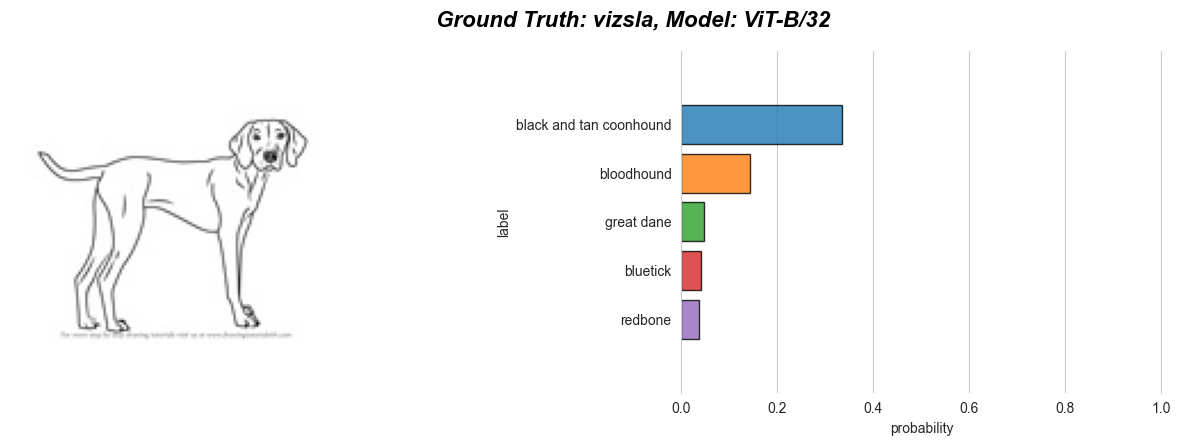

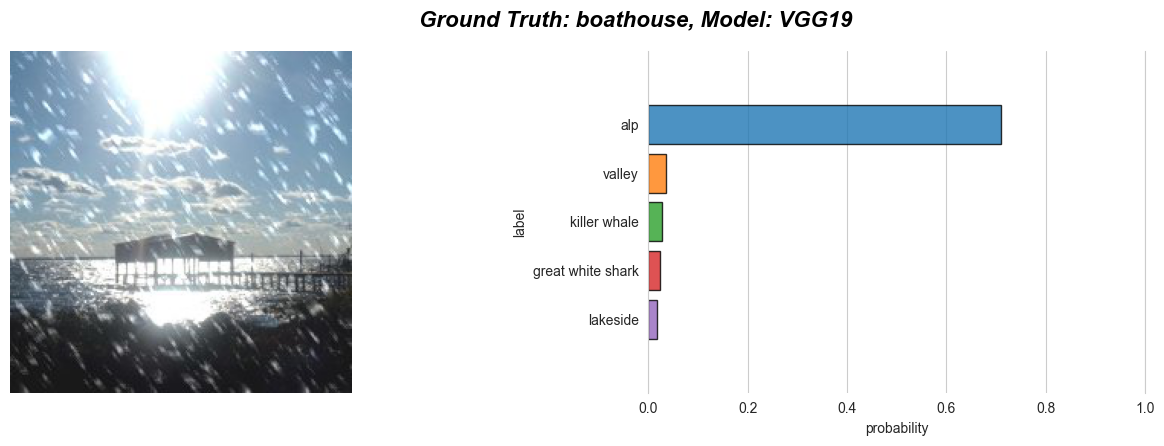

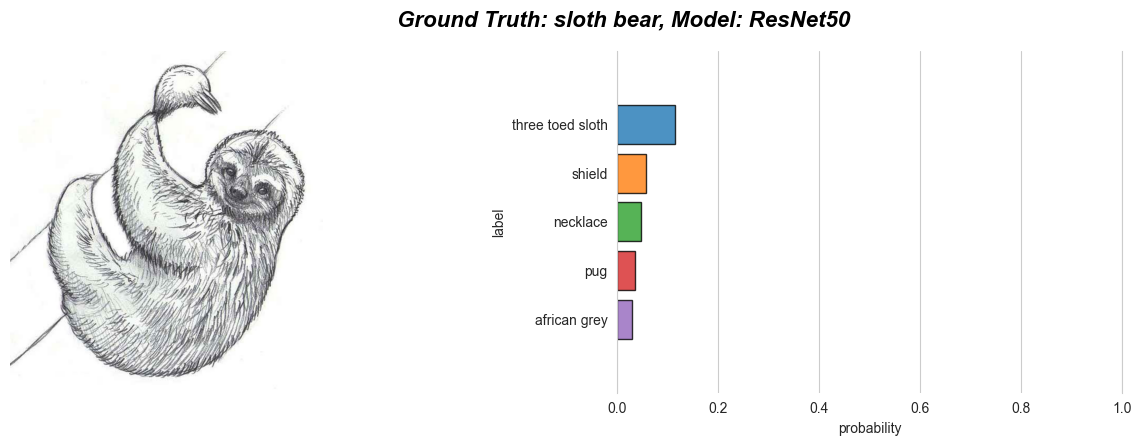

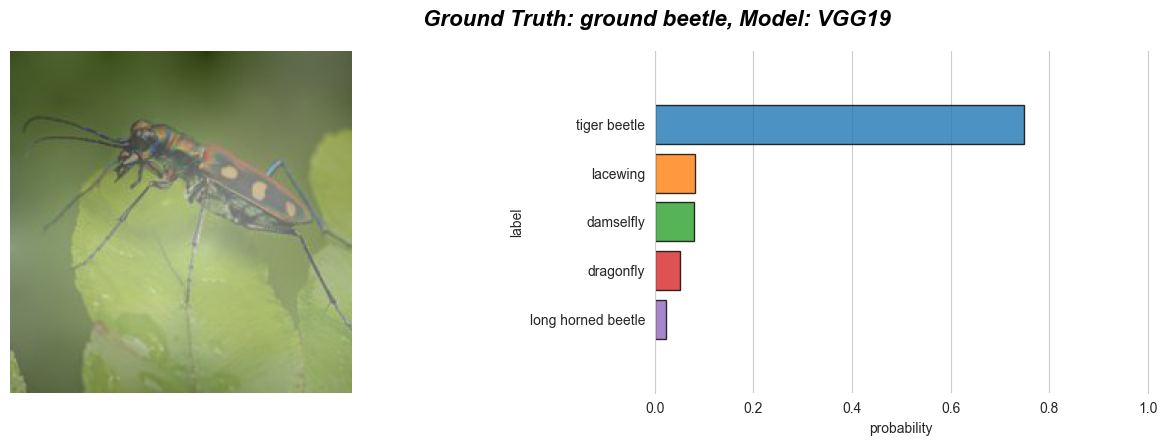

In [54]:
pretty_model_names = {
    "resnet50": "ResNet50",
    "resnet18": "ResNet18",
    "alexnet": "AlexNet",
    "vgg19": "VGG19",
    "vit_b_32": "ViT-B/32",
}

for i in np.random.randint(0, len(imagenet_hard_dataset), 4):
    rname = np.random.choice(model_names)
    model = models.__dict__[rname](pretrained=True)
    plot_image(model, pretty_model_names[rname], int(i))